# Here I will simply build a classifier that detects the presence of a red ball or not in the training imagaes.
    - First build classifier
    - Then try to do the sliding window thing.
    - I think the purpose of sliding window is so we know the new location of the ball. E.g. If we find ball in top right then move in that direction.

In [179]:
# imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
# Define dirs
pos_img_dir = 'TrainingImages/positives/'
neg_img_dir = 'TrainingImages/negatives/'

In [185]:
# go through negatives

neg_len = len( os.listdir(neg_img_dir) )
print ( neg_len )    # 308 long

neg_greyscale = np.zeros((neg_len,51,51))
neg_label = np.zeros((neg_len))

counter = 0
for filename in os.listdir(neg_img_dir):
    print('Image {}/{}'.format(counter+1, neg_len) )

    neg_greyscale[counter,:,:] = Image.open(neg_img_dir + filename).convert('L') # Convert('L') to grey

    #plt.imshow(img)
    #plt.show()
    counter += 1


Image 1351/2600
Image 1352/2600
Image 1353/2600
Image 1354/2600
Image 1355/2600
Image 1356/2600
Image 1357/2600
Image 1358/2600
Image 1359/2600
Image 1360/2600
Image 1361/2600
Image 1362/2600
Image 1363/2600
Image 1364/2600
Image 1365/2600
Image 1366/2600
Image 1367/2600
Image 1368/2600
Image 1369/2600
Image 1370/2600
Image 1371/2600
Image 1372/2600
Image 1373/2600
Image 1374/2600
Image 1375/2600
Image 1376/2600
Image 1377/2600
Image 1378/2600
Image 1379/2600
Image 1380/2600
Image 1381/2600
Image 1382/2600
Image 1383/2600
Image 1384/2600
Image 1385/2600
Image 1386/2600
Image 1387/2600
Image 1388/2600
Image 1389/2600
Image 1390/2600
Image 1391/2600
Image 1392/2600
Image 1393/2600
Image 1394/2600
Image 1395/2600
Image 1396/2600
Image 1397/2600
Image 1398/2600
Image 1399/2600
Image 1400/2600
Image 1401/2600
Image 1402/2600
Image 1403/2600
Image 1404/2600
Image 1405/2600
Image 1406/2600
Image 1407/2600
Image 1408/2600
Image 1409/2600
Image 1410/2600
Image 1411/2600
Image 1412/2600
Image 14

In [186]:
# go through positives

pos_len = len( os.listdir(pos_img_dir) )
print ( pos_len )    # 308 long

pos_greyscale = np.zeros((pos_len,51,51))
pos_label = np.ones((pos_len))

counter = 0
for filename in os.listdir(pos_img_dir):
    print('Image {}/{}'.format(counter+1, pos_len) )
    
    pos_greyscale[counter,:,:] = Image.open(pos_img_dir + filename).convert('L') # Convert('L') to grey
    pos_greyscale[counter,:,:]
    #plt.imshow(img)
    #plt.show()
    counter += 1


308
Image 1/308
Image 2/308
Image 3/308
Image 4/308
Image 5/308
Image 6/308
Image 7/308
Image 8/308
Image 9/308
Image 10/308
Image 11/308
Image 12/308
Image 13/308
Image 14/308
Image 15/308
Image 16/308
Image 17/308
Image 18/308
Image 19/308
Image 20/308
Image 21/308
Image 22/308
Image 23/308
Image 24/308
Image 25/308
Image 26/308
Image 27/308
Image 28/308
Image 29/308
Image 30/308
Image 31/308
Image 32/308
Image 33/308
Image 34/308
Image 35/308
Image 36/308
Image 37/308
Image 38/308
Image 39/308
Image 40/308
Image 41/308
Image 42/308
Image 43/308
Image 44/308
Image 45/308
Image 46/308
Image 47/308
Image 48/308
Image 49/308
Image 50/308
Image 51/308
Image 52/308
Image 53/308
Image 54/308
Image 55/308
Image 56/308
Image 57/308
Image 58/308
Image 59/308
Image 60/308
Image 61/308
Image 62/308
Image 63/308
Image 64/308
Image 65/308
Image 66/308
Image 67/308
Image 68/308
Image 69/308
Image 70/308
Image 71/308
Image 72/308
Image 73/308
Image 74/308
Image 75/308
Image 76/308
Image 77/308
Imag

In [189]:
# Now weve got data in array form we can split into test and train data?
# With GREYSCALE images
# TODO Try with full colour images


X = np.concatenate((neg_greyscale, pos_greyscale))
y = np.concatenate((neg_label, pos_label))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=420,
                                                    shuffle=True)
#Prove test and train data is split correctly
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2326, 51, 51)
(2326,)
(582, 51, 51)
(582,)


In [111]:
X = np.dstack((neg_greyscale, pos_greyscale))
print(X[0].shape)
y = np.concatenate((neg_label, pos_label))
y.shape
#X.shape
print(X[:,:,1].shape)

(51, 2908)
(51, 51)


In [120]:
X = np.concatenate((neg_greyscale, pos_greyscale))
print(X.shape)
neg_greyscale.shape

(2908, 51, 51)


(2600, 51, 51)

In [165]:
#

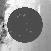

In [178]:
from PIL import Image
hello = Image.open('TrainingImages\positives\positivePatch_28.jpg').convert('L')
hello

<class 'PIL.JpegImagePlugin.JpegImageFile'>


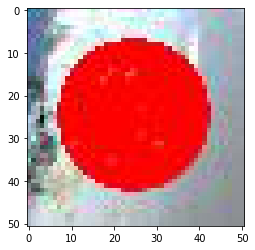

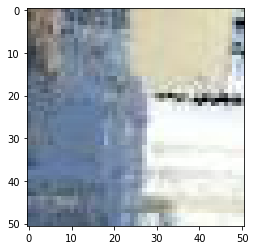

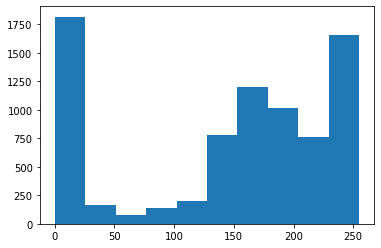

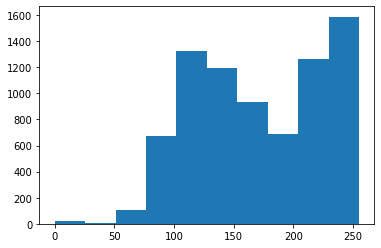

In [196]:
posimg = pos_img_dir + 'positivePatch_28.jpg'
negimg = neg_img_dir + 'negativePatch_3.jpg'

np_pos_img = Image.open(posimg)
np_neg_img = Image.open(negimg)

print(type(np_pos_img))
plt.imshow(np_pos_img)
plt.show()
plt.imshow(np_neg_img)
plt.show()


plt.hist(np.asarray(np_pos_img).ravel())
plt.show()
plt.hist(np.asarray(np_neg_img).ravel())
plt.show()

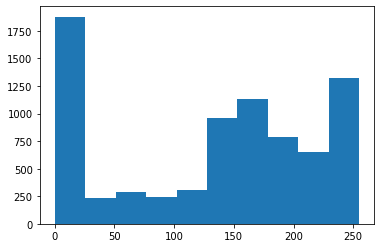

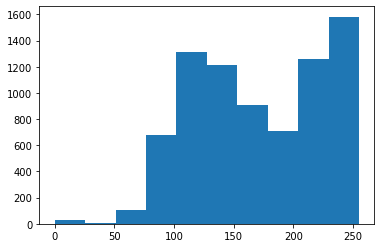

In [28]:
# look at histogram of pixel intensities for pos and neg

posimg = pos_img_dir + 'positivePatch_3.jpg'
negimg = neg_img_dir + 'negativePatch_3.jpg'

np_pos_img = cv2.imread(posimg)
np_neg_img = cv2.imread(negimg)

plt.hist(np_pos_img.ravel())
plt.show()
plt.hist(np_neg_img.ravel())
plt.show()

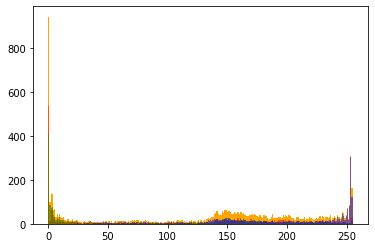

In [31]:
plt.hist(np_pos_img.ravel(), bins = 256, color = 'orange', );
plt.hist(np_pos_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5);
plt.hist(np_pos_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5);
plt.hist(np_pos_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5);

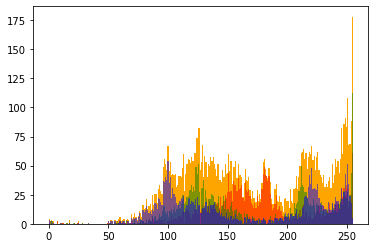

In [32]:
plt.hist(np_neg_img.ravel(), bins = 256, color = 'orange', );
plt.hist(np_neg_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5);
plt.hist(np_neg_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5);
plt.hist(np_neg_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5);